# 03 Experiments:

In [1]:
!pip install -q langchain_openai
!pip install -q faiss-cpu
!pip install -q langchain-community
!pip install -q bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.3/414.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
tqdm.pandas()
from openai import OpenAI
from bert_score import score
import os
import re
import ast
import random
import numpy as np

from langchain_openai import OpenAIEmbeddings
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
pd.set_option('display.max_columns',None)

In [ ]:
#Insert an OpenAI-API-key 
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",
    api_key='')

<h3>Dataset import</h3>

In [3]:
df_feat = pd.read_parquet('https://swp-mvp-media.s3.us-east-1.amazonaws.com/data/02_processed/ABT_feats.parquet')
df_feat.sample()

,USER_ID,FK_GAME_NAME,GAMEPLAY_HOURS,release_from_now,Estimated owners,Peak CCU,Price,DLC count,About the game,Supported languages,Reviews,Achievements,Recommendations,Notes,Categories,Genres,Tags
8509,11403772,tinyandbiggrandpasleftovers,0.9,4632.0,750000.0,1,1.49,0,"Tiny &amp; Big, a comic styled jump and slice ...","['English', 'German', 'French', 'Italian', 'Sp...",“Absorbing gameplay and presentation combined ...,53,2672,None,"Single-player,Steam Achievements,Full controll...",Indie,"Indie,Physics,Platformer,Puzzle,Great Soundtra..."


In [4]:
df_feat.GAMEPLAY_HOURS.describe(percentiles=np.arange(0.7,0.99,0.01)).reset_index().transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
index,count,mean,std,min,50%,70%,71%,72%,73%,74%,75%,76%,77%,78%,79%,80%,81%,82%,83%,84%,85%,86%,87%,88%,89%,90%,91%,92%,93%,94%,95%,96%,97%,98%,99%,max
GAMEPLAY_HOURS,91803.0,31.962298,194.719027,0.0,0.7,4.8,5.3,5.8,6.4,7.0,7.7,8.4,9.2,10.1,11.0,12.1,13.3,14.6,16.0,17.9,19.9,22.0,25.0,29.0,33.0,38.0,45.0,53.0,64.0,81.0,105.0,142.0,207.94,339.0,677.98,11754.0


In [5]:
df_feat['GAMEPLAY_HOURS_FE'] = np.select(
    [
        df_feat.GAMEPLAY_HOURS<=1,
        (df_feat.GAMEPLAY_HOURS>1)&(df_feat.GAMEPLAY_HOURS<=10),
        (df_feat.GAMEPLAY_HOURS>10)&(df_feat.GAMEPLAY_HOURS<=24),
        (df_feat.GAMEPLAY_HOURS>24)&(df_feat.GAMEPLAY_HOURS<=60),
        df_feat.GAMEPLAY_HOURS>60
    ],
    [0,1,2,3,4]
)

df_colab = df_feat.groupby(['USER_ID','FK_GAME_NAME']).GAMEPLAY_HOURS_FE.sum().reset_index()
df_title_counter = df_feat.groupby(['USER_ID']).FK_GAME_NAME.count().reset_index()
df_colab = df_colab[df_colab.USER_ID.isin(df_title_counter[df_title_counter.FK_GAME_NAME>1].USER_ID)]

df_colab['FK_GAME_NAME_WEIGHTED'] = (df_colab['FK_GAME_NAME']+',') * df_colab['GAMEPLAY_HOURS_FE']
df_colab = df_colab[df_colab['FK_GAME_NAME_WEIGHTED']!='']
df_colab['FK_GAME_NAME_WEIGHTED'] = df_colab['FK_GAME_NAME_WEIGHTED'].apply(lambda x:x[:-1])
df_colab = df_colab.groupby('USER_ID')['FK_GAME_NAME_WEIGHTED'].agg(list).reset_index()
df_colab.head()

,USER_ID,FK_GAME_NAME_WEIGHTED
0,5250,"[alienswarm, citiesskylines,citiesskylines,cit..."
1,76767,"[banished,banished, callofdutyblackops,callofd..."
2,86540,"[audiosurf,audiosurf,audiosurf, farcry3,farcry..."
3,181212,[counterstrike]
4,229911,"[callofdutyblackops, counterstrike,counterstri..."


In [6]:
#Setting Tranning and Validation DataSet
validation_size = 0.1
validation_IDS = df_colab.groupby('USER_ID').FK_GAME_NAME_WEIGHTED.count()\
  .reset_index()\
  .sample(int(round(df_feat.USER_ID.nunique()*validation_size,0)), random_state=1)\
  .USER_ID.to_list()

df_colab['game_counter'] = df_colab.FK_GAME_NAME_WEIGHTED.apply(lambda x: len(x))
df_colab = df_colab[df_colab.game_counter>1]
df_colab.drop(columns='game_counter',inplace=True)

df_train = df_colab[~df_colab.USER_ID.isin(validation_IDS)]
df_validation = df_colab[df_colab.USER_ID.isin(validation_IDS)]

print(df_train.USER_ID.nunique(),df_validation.USER_ID.nunique())
df_train.sample()

2705 817


<ipython-input-6-7373a15a8417>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_colab.drop(columns='game_counter',inplace=True)


,USER_ID,FK_GAME_NAME_WEIGHTED
1158,67965357,"[archeblade,archeblade, clickerheroes,clickerh..."


In [7]:
index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

doc_list=[]
index_list=[]
for i in df_train.iterrows():
  context = i[1]['FK_GAME_NAME_WEIGHTED']
  ID = i[1]['USER_ID']
  doc = Document(
      page_content=str(context),
      )
  doc_list.append(doc)
  index_list.append(ID)

vector_store.add_documents(
documents = doc_list,
ids=index_list
)

[5250,
 86540,
 229911,
 547685,
 554278,
 561758,
 748719,
 871990,
 975449,
 994489,
 1072465,
 1129452,
 1612666,
 1950243,
 2039434,
 2083767,
 2259650,
 2428602,
 2531540,
 2753525,
 3244702,
 3449240,
 3783783,
 3979930,
 4064412,
 4595423,
 4877411,
 5220782,
 5270060,
 5387470,
 5860071,
 5949488,
 5976642,
 5990132,
 6144819,
 6252885,
 6439568,
 6928806,
 7015471,
 7020135,
 7163917,
 7249363,
 7273540,
 7418489,
 7440594,
 7907686,
 7955670,
 8542204,
 8585433,
 8763960,
 8795607,
 8865447,
 9128105,
 9180659,
 9245216,
 9563573,
 9845449,
 9946133,
 10181060,
 10218563,
 10253354,
 10302000,
 10385370,
 10595342,
 10608804,
 10856494,
 10934310,
 11024186,
 11149819,
 11161178,
 11207650,
 11300897,
 11373749,
 11403772,
 11731710,
 11794760,
 11807754,
 11940338,
 11952990,
 11970504,
 12130111,
 12144171,
 12195913,
 12259303,
 12423315,
 12610800,
 12660489,
 12760368,
 12860805,
 12985315,
 13190476,
 13227113,
 13336286,
 13556140,
 13646256,
 13863290,
 14153959,
 144

In [10]:
eval_dict={}

for purchased_games in df_validation['FK_GAME_NAME_WEIGHTED']:
  purchased_games = list(set(purchased_games))
  n_context = int(len(purchased_games)/2)
  list_inference = random.sample(purchased_games, n_context)
  list_VR = list(set(purchased_games)-set(list_inference))
  inference = ' '.join(list_inference)

  results = vector_store.similarity_search(
    str(inference),
    k=n_context,
    )

  colab_base_rec = [result.page_content for result  in results]
  colab_base_rec = re.sub(r'\b(\w+)\s*,\s*\1\b', r'\1', colab_base_rec[0])
  colab_base_rec = ast.literal_eval(colab_base_rec)
  colab_base_rec = list(set(colab_base_rec)-set(list_inference))
  eval = len(list(set(list_VR).intersection(set(colab_base_rec))))/len(list_VR)
  eval_dict[str(purchased_games)]={}
  eval_dict[str(purchased_games)]['purchased']=list_inference
  eval_dict[str(purchased_games)]['recommended']=colab_base_rec
  eval_dict[str(purchased_games)]['evaluation']=eval

eval_dict = pd.DataFrame.from_dict(eval_dict).transpose()
eval_dict['fl_acerto'] = np.where(eval_dict.evaluation>0,1,0)

********** Collaborative filter results **********
Mean of right suggestions:  0.04233265254642436
Mean of users that purchased at least 1 suggestions:  0.15676359039190899


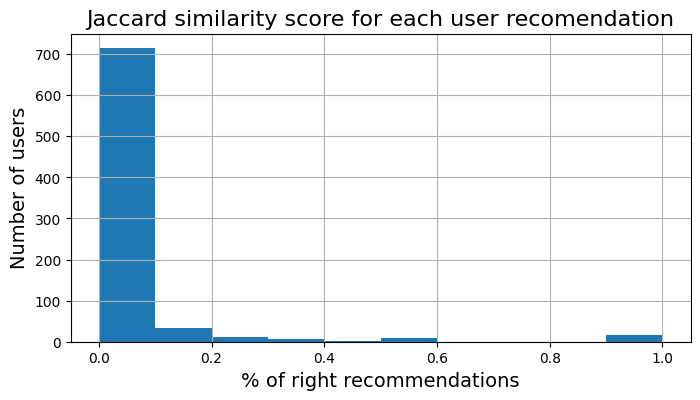

In [14]:
# METRICS
print("*"*10,"Collaborative filter results","*"*10)
print("Mean of right suggestions: ",eval_dict.evaluation.mean())
print("Mean of users that purchased at least 1 suggestions: ",eval_dict.fl_acerto.mean())
plt.figure(figsize=(8, 4))
eval_dict['evaluation'].hist()
plt.title('Jaccard similarity score for each user recomendation', fontsize=16)
plt.xlabel('% of right recommendations', fontsize=14)
plt.ylabel('Number of users', fontsize=14)
plt.show()

In [20]:
# SEMANTIC SIMILARITY - BERTScore
eval_dict['purchased'] = eval_dict['purchased'].apply(lambda x: ' '.join(x))
eval_dict['recommended'] = eval_dict['recommended'].apply(lambda x: ' '.join(x))
P, R, F1 = score(
    eval_dict['recommended'].to_list(),
    eval_dict['purchased'].to_list(),
    lang='en')
eval_dict['Bert_precision']=P.mean().item()
eval_dict['Bert_recall']=R.mean().item()
eval_dict['Bert_f1']=F1.mean().item()

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
eval_dict['Bert_precision'].describe()

,Bert_precision
count,791.000000
mean,0.834799
std,0.000000
min,0.834799
25%,0.834799
50%,0.834799
75%,0.834799
max,0.834799


In [22]:
eval_dict['Bert_recall'].describe()

,Bert_recall
count,791.000000
mean,0.834901
std,0.000000
min,0.834901
25%,0.834901
50%,0.834901
75%,0.834901
max,0.834901


In [23]:
eval_dict['Bert_f1'].describe()

,Bert_f1
count,791.000000
mean,0.834272
std,0.000000
min,0.834272
25%,0.834272
50%,0.834272
75%,0.834272
max,0.834272
